In [123]:
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')

## Load and Combine Data
There are 9 dataframes in this dataset covering various aspects of the business:
- customers: containing customers location information
- products: containing key prouct measurements and pricing
- locations: geospatial information
- order item: key dataframe with each item within each order, along with price and freight value
- payments: containing payment details including type of payment and installments
- reviews: reviews for each order with rating and comments (comments are in Portuguese so difficult to use for NLP)
- orders: information pertaining to each individual order. Key dataframe as it links most others together and contains delivery timeframe information
- sellers: contains sellers location information
- translation: translates the product category information from Portuguese to English

In [124]:
prod = pd.read_csv('./datasets/olist_products_dataset.csv')

In [125]:
cust = pd.read_csv('./datasets/olist_customers_dataset.csv')
loc = pd.read_csv('./datasets/olist_geolocation_dataset.csv')
order_items = pd.read_csv('./datasets/olist_order_items_dataset.csv')
pay = pd.read_csv('./datasets/olist_order_payments_dataset.csv')
reviews = pd.read_csv('./datasets/olist_order_reviews_dataset.csv')
orders = pd.read_csv('./datasets/olist_orders_dataset.csv')
seller = pd.read_csv('./datasets/olist_sellers_dataset.csv')
trans = pd.read_csv('./datasets/product_category_name_translation.csv')

##### Start by translating the category information

In [126]:
prod = prod.merge(trans, on='product_category_name').drop('product_category_name', axis=1)

##### Now lets take a look at the shapes of our dataframes

In [127]:
print("products     ", prod.shape) #merged successfully
print("customers    ", cust.shape) #merged successfully
print("locations    ", loc.shape)
print("ordered items", order_items.shape) #Max rows : don't want the final df to be longer than this. Start with this dataframe
print("payments     ", pay.shape) #merged successfully with alterations to original dataframe
print("reviews      ", reviews.shape) #merged successfully with alterations to original dataframe
print("orders       ", orders.shape) #merged successfully
print("sellers      ", seller.shape) #merged successfully
print("translation  ", trans.shape) #product category name already in english in products df


products      (32328, 9)
customers     (99441, 5)
locations     (1000163, 5)
ordered items (112650, 7)
payments      (103886, 5)
reviews       (100000, 7)
orders        (99441, 8)
sellers       (3095, 4)
translation   (71, 2)


##### As the ordered items contains the most rows as well as the key information that we want to connect with others, I will start with this as the main dataframe and connect all others to it using the keys provided in the data schema

In [128]:
df = order_items.merge(orders, how='left', on='order_id')

In [129]:
df = df.merge(prod, how='left', on='product_id')

In [130]:
df = df.merge(seller, how='left', on='seller_id')

In [131]:
df = df.merge(cust, how='left', on='customer_id')

In [132]:
# df = df.merge(pay, how='left', on='order_id', ) 

##### Adding on the payments  caused the dataframe to increase in length, I will need to look into why this has occured

In [133]:
df.shape

(112650, 29)

#### Check out duplicate order ids in the pay dataframe

In [187]:
#creation of a list of order_ids where there are several payments for the order

def duplicate_list(df, col):
    """
       Takes a dataframe and a column within that dataframe and 
       returns a list of duplicate values within that column
       
       Parameters:
       df
         pandas dataframe
       col
         string of column name
         
       Returns:
       list
         a list of duplicate values 
         
    """
    col_vc = df[col].value_counts()
    duplicates = col_vc[col_vc>1].index.tolist()
    return duplicates

In [188]:
duplicate_payments = duplicate_list(pay,'order_id')

In [189]:
duplicate_payments[0:10]

['fa65dad1b0e818e3ccc5cb0e39231352',
 'ccf804e764ed5650cd8759557269dc13',
 '285c2e15bebd4ac83635ccc563dc71f4',
 '895ab968e7bb0d5659d16cd74cd1650c',
 'fedcd9f7ccdc8cba3a18defedd1a5547',
 'ee9ca989fc93ba09a6eddc250ce01742',
 '21577126c19bf11a0b91592e5844ba78',
 '4bfcba9e084f46c8e3cb49b0fa6e6159',
 '4689b1816de42507a7d63a4617383c59',
 '3c58bffb70dcf45f12bdf66a3c215905']

In [191]:
pay[pay['order_id'] == 'fa65dad1b0e818e3ccc5cb0e39231352'].head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
4885,fa65dad1b0e818e3ccc5cb0e39231352,27,voucher,1,66.02
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
17274,fa65dad1b0e818e3ccc5cb0e39231352,9,voucher,1,1.08
19565,fa65dad1b0e818e3ccc5cb0e39231352,10,voucher,1,12.86


##### Duplicates are shown to be several different 'payments' on the same order, not actually duplicate rows
##### I want to drop rows where there are several payments but I don't want to lose this information so I will create summary columns for each of these and then add those to the main dataframe.


##### Summarising each of the columns for each of the duplicate rows:

In [140]:
payment_value = []
payment_sequential = []
payment_type = []
payment_installments = []
for n in duplicate_payments:    
    payment_value.append(pay[pay['order_id'] == n].sum()["payment_value"])
    payment_sequential.append(pay[pay['order_id'] == n].count()["payment_sequential"])
    payment_type.append(pay[pay['order_id'] == n].mode()["payment_type"][0])
    payment_installments.append(pay[pay['order_id'] == n].mode()["payment_installments"][0])

##### Creation of a new dataframe containing the summarised data

In [192]:
pay_additionals = pd.DataFrame({'order_id' : duplicate_payments, 
                                'payment_sequential' : payment_sequential, 
                                'payment_type' : payment_type,
                                'payment_installments' : payment_installments, 
                                'payment_value' : payment_value})

In [193]:
pay_additionals.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,fa65dad1b0e818e3ccc5cb0e39231352,29,voucher,1.0,457.99
1,ccf804e764ed5650cd8759557269dc13,26,voucher,1.0,62.68
2,285c2e15bebd4ac83635ccc563dc71f4,22,voucher,1.0,40.85
3,895ab968e7bb0d5659d16cd74cd1650c,21,voucher,1.0,161.32
4,fedcd9f7ccdc8cba3a18defedd1a5547,19,voucher,1.0,205.74


##### Combine with original data

In [143]:
final_pay = pay_additionals.append(pay)

##### Drop duplicates, keeping first, which are the new summarised rows

In [144]:
final_pay.drop_duplicates(subset='order_id', inplace=True)

In [145]:
final_pay.shape

(99440, 5)

In [146]:
df = df.merge(final_pay, how='left', on='order_id')

In [147]:
df.shape

(112650, 33)

##### Creation of a list of order_ids where there are several reviews for the order

In [148]:
duplicate_orders_rev = duplicate_list(reviews,'order_id')

In [194]:
# sum(reviews_order_vc[reviews_order_vc>1]) 
# returned 1114

In [195]:
len(duplicate_orders_rev)

555

##### 1114 review ids across 55 order ids

##### Investigation of a few of these order numbers to see what's going on

In [153]:
reviews[reviews['order_id'] == 'c88b1d1b157a9999ce368f218a407141']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
1997,ffb8cff872a625632ac983eb1f88843c,c88b1d1b157a9999ce368f218a407141,3,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:41:07
83187,202b5f44d09cd3cfc0d6bd12f01b044c,c88b1d1b157a9999ce368f218a407141,5,NaN,NaN,2017-07-22 00:00:00,2017-07-26 13:40:22
90069,fb96ea2ef8cce1c888f4d45c8e22b793,c88b1d1b157a9999ce368f218a407141,5,NaN,NaN,2017-07-21 00:00:00,2017-07-26 13:45:15


In [154]:
df[df['order_id'] == 'c88b1d1b157a9999ce368f218a407141']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
88316,c88b1d1b157a9999ce368f218a407141,1,b1acb7e8152c90c9619897753a75c973,cc419e0650a3c5ba77189a1882b7556a,2017-07-26 22:50:12,34.99,7.78,ae0fb7b01c548c4fd30f19f55453ec4a,delivered,2017-07-17 22:44:23,...,santo andre,SP,b64ebaf3d11b7209fe566364cc359a51,9690,sao bernardo do campo,SP,1.0,credit_card,4.0,42.77


In [155]:
reviews[reviews['order_id'] == 'df56136b8031ecd28e200bb18e6ddb2e']


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
2970,c444278834184f72b1484dfe47de7f97,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-08 00:00:00,2017-02-14 13:58:48
14084,72a1098d5b410ae50fbc0509d26daeb9,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-07 00:00:00,2017-02-10 10:46:09
63225,44f3e54834d23c5570c1d010824d4d59,df56136b8031ecd28e200bb18e6ddb2e,5,NaN,NaN,2017-02-09 00:00:00,2017-02-09 09:07:28


In [156]:
df[df['order_id'] == 'df56136b8031ecd28e200bb18e6ddb2e'].T

,98466,98467,98468
order_id,df56136b8031ecd28e200bb18e6ddb2e,df56136b8031ecd28e200bb18e6ddb2e,df56136b8031ecd28e200bb18e6ddb2e
order_item_id,1,2,3
product_id,f28cbd414cd06f1ae84065c8dd8be834,50aa8f292a9510d5542f2a078903a2a7,3025303c80b01a0926fda2841cc31b4a
seller_id,4da0e408c99d2fdc2126dc9fce518060,834f8533b2ecb6598dd004ff3de7203a,4da0e408c99d2fdc2126dc9fce518060
shipping_limit_date,2017-01-30 13:15:41,2017-01-30 13:15:41,2017-01-30 13:15:41
price,23.9,63.92,66.9
freight_value,2.53,15.82,31.65
customer_id,b7770073b02ed1d626a027ce86a4ff82,b7770073b02ed1d626a027ce86a4ff82,b7770073b02ed1d626a027ce86a4ff82
order_status,delivered,delivered,delivered
order_purchase_timestamp,2017-01-26 13:15:41,2017-01-26 13:15:41,2017-01-26 13:15:41


##### Upon visual inspection it seems there are cases where there are only one item for several reviews but also when there are equal ordered items as there are reviews. However, there is no real connection between the review and the item being reviewed so it is hard to know exactly which review relates to what. I would like to check out the frequency of the review number mathching the item number


In [196]:
#iterates through the duplicate order numbers and counts how many items there are against each
item_counts = []
for n in duplicate_orders_rev:
    item_counts.append(len(df[df['order_id'] == n]))

(array([480.,  56.,  10.,   6.,   0.,   2.,   0.,   0.,   0.,   1.]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <a list of 10 Patch objects>)

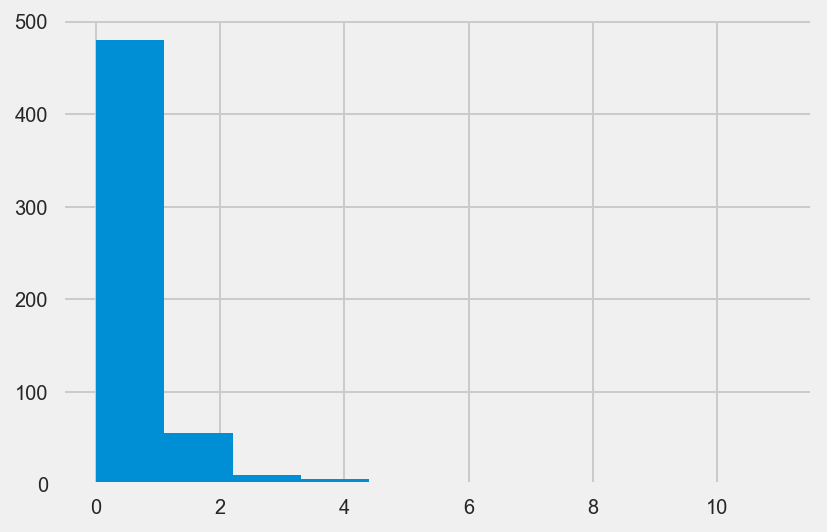

In [197]:
plt.hist(item_counts)

##### From this histogram it is clear that these duplicate reviews are not related to specific items within orders so I will drop them from the reviews dataframe

In [162]:
reviews.drop_duplicates(subset=(['order_id']),keep=False, inplace =True)

In [163]:
reviews.shape

(98886, 7)

In [164]:
#reviews where there are several orders per review
duplicate_reviews_rev = duplicate_list(reviews,'review_id')

In [167]:
len(duplicate_reviews_rev)

344

In [168]:
reviews[reviews['review_id'] == 'e44840754f12fad2b8646712121b349a']

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
7292,e44840754f12fad2b8646712121b349a,fb265b2dc558a56445dfc48f8224e201,4,NaN,NaN,2017-11-01 00:00:00,2017-11-02 00:11:06
48620,e44840754f12fad2b8646712121b349a,57cc72d3e635bf57199d76328279b875,4,NaN,NaN,2017-11-01 00:00:00,2017-11-02 00:11:06
91272,e44840754f12fad2b8646712121b349a,6ceabf34d230c31f161988dd2ff8fa92,4,NaN,NaN,2017-11-01 00:00:00,2017-11-02 00:11:06


In [169]:
df[df['order_id'] == ('fb265b2dc558a56445dfc48f8224e201')].iloc[:,-15:]

,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
110535,25.0,11.0,11.0,health_beauty,12940,atibaia,SP,f50ca6544a0ed8a52cc964e15cbe9cf9,99700,erechim,RS,2.0,credit_card,1.0,131.12


In [170]:
df[df['order_id'] == ('57cc72d3e635bf57199d76328279b875')].iloc[:,-15:]

,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
38643,20.0,40.0,25.0,health_beauty,85853,foz do iguacu,PR,f50ca6544a0ed8a52cc964e15cbe9cf9,99700,erechim,RS,2.0,credit_card,1.0,236.49


In [171]:
df[df['order_id'] == ('6ceabf34d230c31f161988dd2ff8fa92')].iloc[:,-15:]

,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,payment_sequential,payment_type,payment_installments,payment_value
47932,62.0,43.0,56.0,baby,16304,penapolis,SP,f50ca6544a0ed8a52cc964e15cbe9cf9,99700,erechim,RS,2.0,credit_card,1.0,84.15


##### For these you can see that there are muliple orders against each review but they are all from the same customer. As I am unsure why these are in existence and whether the review is for a specific item or all of them, I will drop these order ids from the main dataframe as well

In [173]:
reviews.drop_duplicates(subset=(['review_id']),keep=False, inplace=True)

In [174]:
df = df.merge(reviews, how='left', on='order_id')

In [175]:
df.shape

(112650, 39)

In [176]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,1.0,credit_card,2.0,72.19,97ca439bc427b48bc1cd7177abe71365,5.0,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,...,1.0,credit_card,3.0,259.83,7b07bacd811c4117b742569b04ce3580,4.0,NaN,NaN,2017-05-13 00:00:00,2017-05-15 11:34:13
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,...,1.0,credit_card,5.0,216.87,0c5b33dea94867d1ac402749e5438e8b,5.0,NaN,Chegou antes do prazo previsto e o produto sur...,2018-01-23 00:00:00,2018-01-23 16:06:31
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,...,1.0,credit_card,2.0,25.78,f4028d019cb58564807486a6aaf33817,4.0,NaN,NaN,2018-08-15 00:00:00,2018-08-15 16:39:01
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,...,1.0,credit_card,3.0,218.04,940144190dcba6351888cafa43f3a3a5,5.0,NaN,Gostei pois veio no prazo determinado .,2017-03-02 00:00:00,2017-03-03 10:54:59


##### Now that I have a complete dataframe, I will save to csv for cleaning

In [177]:
df.to_csv(r'/Users/elkehansen/Documents/general_assembly/Capstone-Subsmission/Elke/datasets/complete-df.csv', index=False)